# Reinforcement Learning using Custom Environment:

## Importing dependencies:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#### World description:

This is a Grid World where the player has to start from the top left corner of the grid and make it all the way 
to the bottom right one.

Sounds easy right?

But here's the catch, the grid consists of some teleporters, which can teleport the player from one point to another on the grid, 
completely free of cost. 
The player has to reach the destination in the minimum possible steps and attain the maximum possible reward.

## Creating the Grid World Class:

In [2]:
class GridWorld(object):
    def __init__(self, m, n, magicSquares, startPosition=0):
        self.grid = np.zeros((m, n))
        self.m = m
        self.n = n
        self.stateSpace = [i for i in range(self.m * self.n)]
        self.stateSpace.remove(80)
        self.stateSpacePlus = [i for i in range(self.m * self.n)]
        self.actionSpace = {
            'U': -self.m,
            'D': self.m,
            'L': -1,
            'R': 1
        }
        self.possibleActions = ['U', 'D', 'L', 'R']
        self.addMagicSquares(magicSquares)
        self.agentPosition = startPosition

    def isTerminalState(self, state):
        return state in self.stateSpacePlus and state not in self.stateSpace

    def addMagicSquares(self, magicSquares):
        self.magicSquares = magicSquares
        i = 2  # Start labeling with 2 for magic squares
        for start_square, end_square in self.magicSquares.items():
            x_start = start_square // self.n
            y_start = start_square % self.n
            self.grid[x_start][y_start] = i
            i += 1
            x_end = end_square // self.n
            y_end = end_square % self.n
            self.grid[x_end][y_end] = i
            i += 1

    def getAgentRowAndColumn(self):
        x = self.agentPosition // self.n
        y = self.agentPosition % self.n
        return x, y

    def setState(self, state):
        x, y = self.getAgentRowAndColumn()
        self.grid[x][y] = 0
        self.agentPosition = state
        x, y = self.getAgentRowAndColumn()
        self.grid[x][y] = 1

    def offGridMove(self, newState, oldState):
        if newState not in self.stateSpacePlus:
            return True
        elif oldState % self.n == 0 and newState % self.n == self.n - 1:
            return True
        elif oldState % self.n == self.n - 1 and newState % self.n == 0:
            return True
        else:
            return False

    def step(self, action):
        agentX, agentY = self.getAgentRowAndColumn()
        resultingState = self.agentPosition + self.actionSpace[action]
        if resultingState in self.magicSquares:
            resultingState = self.magicSquares[resultingState]
    
        reward = -1 if not self.isTerminalState(resultingState) else 0
        if not self.offGridMove(resultingState, self.agentPosition):
            self.setState(resultingState)
            return resultingState, reward, self.isTerminalState(resultingState), None
        else:
            return self.agentPosition, reward, self.isTerminalState(self.agentPosition), None

    def reset(self):
        self.agentPosition = 0
        self.grid = np.zeros((self.m, self.n))
        self.addMagicSquares(self.magicSquares)
        return self.agentPosition

    def render(self):
        print('**************************************************')
        for row in self.grid:
            for col in row:
                if col == 0:
                    print('-', end='\t')
                elif col == 1:
                    print('P', end='\t')
                elif col == 2:
                    print('Ain', end='\t')
                elif col == 3:
                    print('Aout', end='\t')
                elif col == 4:
                    print('Bin', end='\t')
                elif col == 5:
                    print('Bout', end='\t')
            print('\n')
        print('**************************************************')

    def actionSpaceSample(self):
        return np.random.choice(self.possibleActions)


### Creating the Max Action function:

In [3]:
def maxAction(Q, state, actions):
    values = np.array([Q[state, a] for a in actions])
    action = np.argmax(values)
    return actions[action]

### Defining hyperparameters:

In [4]:
magicSquares = {18 : 54, 63 : 9}

env = GridWorld(9, 9, magicSquares)

ALPHA = 0.1  # Learning Rate
GAMMA = 1.0  # Discount Factor
EPS = 1.0    # Epsilon

Q = {}
for state in env.stateSpacePlus:
    for action in env.possibleActions:
        Q[state, action] = 0

num_games = 70000
totalRewards = np.zeros(num_games)
env.render()

**************************************************
-	-	-	-	-	-	-	-	-	

Bout	-	-	-	-	-	-	-	-	

Ain	-	-	-	-	-	-	-	-	

-	-	-	-	-	-	-	-	-	

-	-	-	-	-	-	-	-	-	

-	-	-	-	-	-	-	-	-	

Aout	-	-	-	-	-	-	-	-	

Bin	-	-	-	-	-	-	-	-	

-	-	-	-	-	-	-	-	-	

**************************************************


### Starting the Training Loop:

In [5]:
for i in range(num_games):
    if i % 5000 == 0:
        print(f'Starting game : {i}')
    done = False
    epRewards = 0
    observation = env.reset()
    while not done:
        rand = np.random.random()
        action = maxAction(Q, observation, env.possibleActions) if rand < (1-EPS) else env.actionSpaceSample()

        observation_, reward, done, info = env.step(action)
        epRewards += reward
        action_ = maxAction(Q, observation_, env.possibleActions)
        Q[observation, action] = Q[observation, action] + ALPHA * (reward + GAMMA * Q[observation_, action_] - Q[observation, action])
        observation = observation_

    if EPS - 2/num_games > 0:
        EPS -= 2/num_games

    else:
        EPS = 0
    totalRewards[i] = epRewards


Starting game : 0
Starting game : 5000
Starting game : 10000
Starting game : 15000
Starting game : 20000
Starting game : 25000
Starting game : 30000
Starting game : 35000
Starting game : 40000
Starting game : 45000
Starting game : 50000
Starting game : 55000
Starting game : 60000
Starting game : 65000


### Plotting the Results:

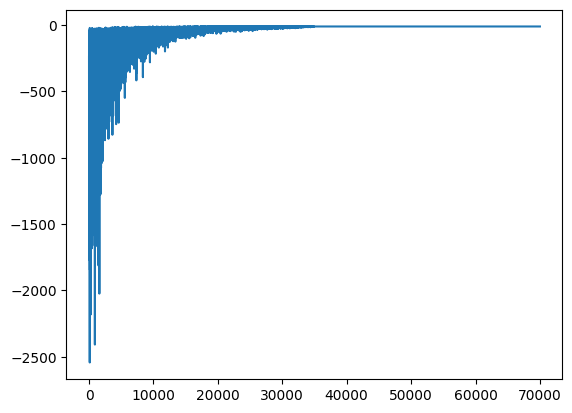

In [6]:
plt.plot(totalRewards)
plt.show()

In [8]:
print(totalRewards[:])

[-241. -968. -729. ...  -11.  -11.  -11.]
